# Intro

In [2]:
import os
import os.path as op

import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import sqlalchemy as sa

from IPython.display import display, HTML
import matplotlib.pyplot as plt

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)

from common import dat

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import seaborn as sns
sns.set_context('notebook', font_scale=2)

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load data

In [ ]:
# Load drug info data

# az_dream
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream')
drug_info_release_3 = pd.read_sql_table('drug_info_release_3', engine)
drug_to_cid = pd.read_sql_table('drug_to_cid', engine)
drug_to_target = pd.read_sql_table('drug_to_target', engine)
all_cell_line_drug_pairs = pd.read_sql_table('all_cell_line_drug_pairs', engine)

# az_dream_data
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_data')
training_gby_drug = pd.read_sql_table('training_gby_drug', engine)
training_gby_drugpair = pd.read_sql_table('training_gby_drugpair', engine)
training_gby_cell = pd.read_sql_table('training_gby_cell', engine)

In [433]:
# training data
training = pd.read_sql_table('training', engine)

In [450]:
main_df = training.copy()

In [539]:
main_df = training_gby_drugpair[['COMBINATION_ID', 'MEAN']].rename(columns={'MEAN': 'SYNERGY_SCORE'})
main_df['COMPOUND_A'], main_df['COMPOUND_B'] = list(zip(*
     main_df['COMBINATION_ID'].apply(lambda x: x.split('.'))
))

In [295]:
# validation data
validation = pd.read_sql_table('ch2_validation', engine)
drug_pairs = sorted(set(validation['COMBINATION_ID']))
cell_lines = sorted(set(validation['CELL_LINE']))

lst = []
cell_lines_df = pd.DataFrame(data=cell_lines, columns=['CELL_LINE'])
for drug_pair in drug_pairs:
    df = cell_lines_df.copy()
    df['COMBINATION_ID'] = drug_pair
    lst.append(df)
big_df = pd.concat(lst)
big_df['COMPOUND_A'], big_df['COMPOUND_B'] = list(zip(*
     big_df['COMBINATION_ID'].apply(lambda x: x.split('.'))
))

validation_sparse = (
    big_df
    .merge(
        validation, 
        on=['COMBINATION_ID','COMPOUND_A', 'COMPOUND_B', 'CELL_LINE'], how='outer')
)

In [475]:
main_df = validation_sparse.copy()

In [585]:
main_df = big_df.copy()

## Drug info

In [20]:
drug_info_release_3.sort_values('CID', inplace=True)

In [21]:
drug_info_release_3.head(2)

,ChallengeName,Target(Official Symbol),HBA,cLogP,HBD,Lipinski,SMILES or PubChem ID,MW,AtomStereoCount,BondStereoCount,CID,CanonicalSMILES,Charge,Complexity,ConformerCount3D,ConformerModelRMSD3D,CovalentUnitCount,DefinedAtomStereoCount,DefinedBondStereoCount,EffectiveRotorCount3D,ExactMass,FeatureAcceptorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureCount3D,FeatureDonorCount3D,FeatureHydrophobeCount3D,FeatureRingCount3D,Fingerprint2D,HBondAcceptorCount,HBondDonorCount,HeavyAtomCount,IUPACName,InChI,InChIKey,IsomericSMILES,IsotopeAtomCount,MolecularFormula,MolecularWeight,MonoisotopicMass,RotatableBondCount,TPSA,UndefinedAtomStereoCount,UndefinedBondStereoCount,Volume3D,XLogP,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,cids,targets,targets_bioentities,enzymes,enzymes_bioentities,transporters,transporters_bioentities,atcs
37,Doxorubicin,"TOP*,DNMT1",12,0.32,7,3,CC1C(C(CC(O1)OC2CC(Cc3c2c(c4c(c3O)C(=O)c5cccc(...,543.5,6,0,1691,CC1C(C(CC(O1)OC2CC(CC3=C(C4=C(C(=C23)O)C(=O)C5...,0,977,0,NaN,1,0,0,NaN,543.174061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAADceB6PAAAAAAAAAAAAAAAAAAAAAAAAAA0YMGCAAAAAA...,12,6,39,"7-(4-amino-5-hydroxy-6-methyloxan-2-yl)oxy-6,9...",InChI=1S/C27H29NO11/c1-10-22(31)13(28)6-17(38-...,AOJJSUZBOXZQNB-UHFFFAOYSA-N,CC1C(C(CC(O1)OC2CC(CC3=C(C4=C(C(=C23)O)C(=O)C5...,0,C27H29NO11,543.51926,543.174061,5,206.0,6,0,NaN,1.3,NaN,NaN,NaN,"1691,31703,32875,41867,83979,151537,153517,308...","DNA,DNA topoisomerase 2-alpha,Chromodomain-hel...","BE0004796,BE0000742,BE0000531","Alcohol dehydrogenase [NADP],Aldo-keto reducta...","BE0004352,BE0000592,BE0003074,BE0004771,BE0001...","ATP-binding cassette sub-family B member 8, mi...","BE0003673,BE0001067,BE0000703,BE0001069,BE0001...","L01DB01,L01DB03"
32,Chloroquine,Thiamine,NaN,NaN,NaN,NaN,2719,NaN,1,0,2719,CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl,0,309,324,0.8,1,0,0,8,319.181526,1,0,2,6,1,0,2,AAADceB7AAAEAAAAAAAAAAAAAAAAAAAAAAA8QAAAAAAAAA...,3,1,22,"4-N-(7-chloroquinolin-4-yl)-1-N,1-N-diethylpen...",InChI=1S/C18H26ClN3/c1-4-22(5-2)12-6-7-14(3)21...,WHTVZRBIWZFKQO-UHFFFAOYSA-N,CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl,0,C18H26ClN3,319.87214,319.181526,8,28.2,1,0,255.7,4.6,10.27,3.1,1.88,"2719,444810,639540,10087451,49849611,49849612,...","Fe-protoporphyrin IX,Glutathione S-transferase...","BE0004805,BE0002659,BE0002189,BE0001171,BE0000704","Cytochrome P450 1A1,Cytochrome P450 2C8,Cytoch...","BE0003543,BE0002887,BE0002363,BE0002638,BE0002362",Multidrug resistance protein 1,BE0001032,P01BA01


# Drug features

In [22]:
training_gby_drug.head()

,COMPOUND,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE
0,ADAM17,85.18,103,6.077150,3.639117,19.048473,20.762748,2.063913,2.045814,0.878415
1,AKT,209.48,257,12.990700,4.981951,26.395353,41.300744,1.823712,2.576270,0.927703
2,AKT_1,149.20,169,16.016789,12.759452,25.594104,30.527971,2.095345,2.348305,0.872394
3,AKT_SGK,46.02,48,10.049147,9.716044,18.992123,18.772570,2.799627,2.709587,0.756963
4,ALK,37.14,51,16.966631,12.950270,20.245268,27.845114,3.322023,3.899096,0.688810


In [586]:
# Add drug synergy scores
main_df = (
    main_df
    .merge(
        training_gby_drug[['COMPOUND', 'LEN', 'MEAN', 'STE']]
        .rename(
            columns={
                'COMPOUND': 'COMPOUND_A',
                'LEN': 'drug_len_A',
                'MEAN': 'drug_mean_A',
                'STE': 'drug_ste_A',
            }),
        on=['COMPOUND_A'], how='left')
    .merge(
        training_gby_drug[['COMPOUND', 'LEN', 'MEAN', 'STE']]
        .rename(
            columns={
                'COMPOUND': 'COMPOUND_B',
                'LEN': 'drug_len_B',
                'MEAN': 'drug_mean_B',
                'STE': 'drug_ste_B',
            }),
        on=['COMPOUND_B'], how='left')
)

In [42]:
x = main_df.corr()['SYNERGY_SCORE']

In [43]:
x.sort_values()

Einf_A          -0.080222
Einf_B          -0.070283
IC50_A          -0.054244
DRUG_LEN_B      -0.023947
MAX_CONC_B      -0.011022
IC50_B          -0.008651
H_B             -0.005458
MAX_CONC_A       0.014226
DRUG_STE_A       0.017906
DRUG_LEN_A       0.026592
H_A              0.027465
QA               0.046226
DRUG_MEAN_A      0.081886
DRUG_MEAN_B      0.096167
DRUG_STE_B       0.131116
SYNERGY_SCORE    1.000000
Name: SYNERGY_SCORE, dtype: float64

In [17]:
columns = [
    'unique_id', 'synergy_score_mean', 'synergy_score_std', 'synergy_score_ste', 
    'synergy_score_confidence'
]
synergy_score = (
    training_gby_drugpair.rename(
        columns={
            'COMBINATION_ID': 'unique_id',
            'LEN': ''
            'MEAN': 'synergy_score_mean',
            'STD': 'synergy_score_std',
            'STE': 'synergy_score_ste',
            'CONFIDENCE': 'synergy_score_confidence'
        })
    [columns]
)
synergy_score.head()

,unique_id,synergy_score_mean,synergy_score_std,synergy_score_ste,synergy_score_confidence
0,ADAM17.AKT,9.506099,18.090624,4.834923,0.625596
1,ADAM17.BCL2_BCL2L1,-3.439654,5.543807,1.600359,0.999478
2,ADAM17.FGFR,-4.934241,17.415001,4.830052,0.625937
3,ADAM17.MAP2K_1,-1.658434,16.004816,4.438937,0.654492
4,ADAM17.MTOR_1,9.511901,17.444983,4.662368,0.637885


# Drug pair features

## Clare

In [47]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_target_features')
original_target_features = pd.read_sql_table('original_target_features', engine)

In [49]:
original_target_features.head()

,unique_id,bg_degree,bg_clustering_coef,bg_betweenness,bg_closeness,bg_neighbor_sharing,bg_shortest_path_length,bg_eb_max,bg_eb_min,bg_eb_mean,bg_eb_fraction,bg_number_of_shortest_paths,coexpression,gene_essentiality,gi_degree,gi_clustering_coef,gi_betweenness,gi_closeness,gi_neighbor_sharing,gi_shortest_path_length,gi_eb_max,gi_eb_min,gi_eb_mean,gi_eb_fraction,gi_number_of_shortest_paths,go_all_sem_sim,go_bp_sem_sim,go_cc_sem_sim,go_mf_sem_sim,go_slim_sem_sim,phylogenic_similarity,s_degree,s_clustering_coef,s_betweenness,s_closeness,s_neighbor_sharing,s_shortest_path_length,eb_max,eb_min,eb_mean,eb_fraction,s_number_of_shortest_paths
0,ADAM17.AKT,47.166667,0.174388,0.000319,0.407483,2.888185,2.000000,0.000232,0.000154,0.000193,100.000000,1.0000,-0.045844,0.925926,33.750000,0.022739,0.000065,0.343499,0.000000,3.00,0.000080,0.000003,0.000017,52.777778,19.5000,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125.000000,0.134330,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333
1,ADAM17.AKT_1,33.800000,0.185718,0.000212,0.390061,1.732911,2.400000,0.003019,0.000093,0.000207,78.062954,9.8000,-0.057905,0.813333,28.333333,0.020605,0.000048,0.339907,0.000000,3.00,0.000069,0.000003,0.000016,55.475040,16.3333,16.637769,16.177050,26.214286,10.769231,54.297882,0.895341,83.700000,0.220766,0.002986,0.311351,0.194932,2.800000,0.000282,0.000005,0.000063,62.840766,74.0000
2,ADAM17.AKT_PIK3C,22.708333,0.218184,0.000129,0.392611,2.895376,2.250000,0.001445,0.000082,0.000160,82.407183,6.0833,0.017456,0.894737,39.050000,0.018360,0.000087,0.344928,0.000000,3.00,0.000060,0.000003,0.000015,48.627057,21.5000,12.312608,10.836258,23.674218,10.315134,52.123868,0.920545,84.846154,0.236257,0.001572,0.309506,0.914699,2.538462,0.000161,0.000005,0.000039,58.735282,37.5385
3,ADAM17.AKT_SGK,32.666667,0.184184,0.000217,0.392386,1.758558,2.333333,0.002564,0.000107,0.000211,81.719128,8.3333,-0.021818,0.869159,31.875000,0.020476,0.000055,0.342243,0.297619,2.75,0.000053,0.000003,0.000013,41.606280,12.5000,15.328771,14.358068,27.592365,10.683761,53.581568,0.898081,76.750000,0.207219,0.002543,0.311779,0.363246,2.666667,0.000240,0.000006,0.000056,60.700638,61.8333
4,ADAM17.ALK,28.500000,0.152926,0.000078,0.367599,1.785714,2.000000,0.000009,0.000006,0.000008,0.000000,1.0000,-0.067054,1.000000,107.500000,0.014053,0.000664,0.367971,0.467290,2.00,0.000027,0.000026,0.000026,100.000000,1.0000,11.805556,8.675799,45.833333,8.888889,48.148148,0.909405,25.500000,0.107161,0.000195,0.294602,0.000000,3.000000,0.000108,0.000002,0.000028,60.937500,39.0000


In [587]:
# Add Clare's features
main_df = (
    main_df
    .merge(
        original_target_features
        .rename(columns={'unique_id': 'COMBINATION_ID'}),
        on=['COMBINATION_ID'], how='left')
)

In [62]:
main_df.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID,drug_len_A,drug_mean_A,drug_ste_A,drug_len_B,drug_mean_B,drug_ste_B,bg_degree,bg_clustering_coef,bg_betweenness,bg_closeness,bg_neighbor_sharing,bg_shortest_path_length,bg_eb_max,bg_eb_min,bg_eb_mean,bg_eb_fraction,bg_number_of_shortest_paths,coexpression,gene_essentiality,gi_degree,gi_clustering_coef,gi_betweenness,gi_closeness,gi_neighbor_sharing,gi_shortest_path_length,gi_eb_max,gi_eb_min,gi_eb_mean,gi_eb_fraction,gi_number_of_shortest_paths,go_all_sem_sim,go_bp_sem_sim,go_cc_sem_sim,go_mf_sem_sim,go_slim_sem_sim,phylogenic_similarity,s_degree,s_clustering_coef,s_betweenness,s_closeness,s_neighbor_sharing,s_shortest_path_length,eb_max,eb_min,eb_mean,eb_fraction,s_number_of_shortest_paths,cell_len,cell_mean,cell_ste
0,BT-20,ADAM17,AKT,1,75,1.000000,0.809002,59.122436,9.639714,0.757977,91.593425,29.540390,1,ADAM17.AKT,85.18,6.07715,2.063913,209.48,12.9907,1.823712,47.166667,0.174388,0.000319,0.407483,2.888185,2,0.000232,0.000154,0.000193,100,1,-0.045844,0.925926,33.75,0.022739,0.000065,0.343499,0,3,0.00008,0.000003,0.000017,52.777778,19.5,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125,0.13433,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333,51.00,22.283808,2.858683
1,CAL-120,ADAM17,AKT,1,75,0.183214,2.503678,60.411999,1.000000,0.000000,100.000000,4.401410,-1,ADAM17.AKT,85.18,6.07715,2.063913,209.48,12.9907,1.823712,47.166667,0.174388,0.000319,0.407483,2.888185,2,0.000232,0.000154,0.000193,100,1,-0.045844,0.925926,33.75,0.022739,0.000065,0.343499,0,3,0.00008,0.000003,0.000017,52.777778,19.5,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125,0.13433,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333,25.11,11.340866,5.006837
2,CAL-51,ADAM17,AKT,1,75,1.000000,0.726984,11.150843,75.000000,0.375043,76.656479,0.315422,1,ADAM17.AKT,85.18,6.07715,2.063913,209.48,12.9907,1.823712,47.166667,0.174388,0.000319,0.407483,2.888185,2,0.000232,0.000154,0.000193,100,1,-0.045844,0.925926,33.75,0.022739,0.000065,0.343499,0,3,0.00008,0.000003,0.000017,52.777778,19.5,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125,0.13433,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333,29.02,6.621544,1.655752
3,DU-4475,ADAM17,AKT,1,75,0.321533,10.000000,58.599487,75.000000,1.995866,6.171007,-41.734090,-1,ADAM17.AKT,85.18,6.07715,2.063913,209.48,12.9907,1.823712,47.166667,0.174388,0.000319,0.407483,2.888185,2,0.000232,0.000154,0.000193,100,1,-0.045844,0.925926,33.75,0.022739,0.000065,0.343499,0,3,0.00008,0.000003,0.000017,52.777778,19.5,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125,0.13433,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333,26.20,2.471677,4.080178
4,HCC1143,ADAM17,AKT,1,75,0.398673,10.000000,89.098894,1.000000,0.000000,100.000000,35.532770,-1,ADAM17.AKT,85.18,6.07715,2.063913,209.48,12.9907,1.823712,47.166667,0.174388,0.000319,0.407483,2.888185,2,0.000232,0.000154,0.000193,100,1,-0.045844,0.925926,33.75,0.022739,0.000065,0.343499,0,3,0.00008,0.000003,0.000017,52.777778,19.5,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125,0.13433,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333,35.06,2.247873,3.316506


In [31]:
set(synergy_score['unique_id']) - set(original_target_features['unique_id'])

{'PIK3CB_PIK3CD.PIK3CB_PIK3CD', 'PIK3C_2.PIK3CA_4'}

In [27]:
original_target_features.shape

(167, 46)

In [35]:
original_target_features.head()

,unique_id,bg_degree,bg_clustering_coef,bg_betweenness,bg_closeness,bg_neighbor_sharing,bg_shortest_path_length,bg_eb_max,bg_eb_min,bg_eb_mean,bg_eb_fraction,bg_number_of_shortest_paths,coexpression,gene_essentiality,gi_degree,gi_clustering_coef,gi_betweenness,gi_closeness,gi_neighbor_sharing,gi_shortest_path_length,gi_eb_max,gi_eb_min,gi_eb_mean,gi_eb_fraction,gi_number_of_shortest_paths,go_all_sem_sim,go_bp_sem_sim,go_cc_sem_sim,go_mf_sem_sim,go_slim_sem_sim,phylogenic_similarity,s_degree,s_clustering_coef,s_betweenness,s_closeness,s_neighbor_sharing,s_shortest_path_length,eb_max,eb_min,eb_mean,eb_fraction,s_number_of_shortest_paths,synergy_score_mean,synergy_score_std,synergy_score_ste,synergy_score_confidence
0,ADAM17.AKT,47.166667,0.174388,0.000319,0.407483,2.888185,2.000000,0.000232,0.000154,0.000193,100.000000,1,-0.045844,0.925926,33.75,0.022739,0.000065,0.343499,0.000000,3.000000,0.000080,0.000003,0.000017,52.777778,19.5000,17.221283,16.986108,26.759259,9.615385,60.119658,0.936001,125.00,0.134330,0.004867,0.322401,0.324886,2.666667,0.000188,0.000004,0.000047,61.817062,114.3333,9.506099,18.090624,4.834923,0.625596
1,ADAM17.BCL2_BCL2L1,44.500000,0.159947,0.000258,0.404494,1.145833,2.000000,0.000265,0.000172,0.000218,100.000000,1,0.025084,1.000000,17.50,0.013199,0.000014,0.310930,1.136364,3.000000,0.000067,0.000015,0.000036,50.000000,1.0000,17.109842,16.724988,23.169399,10.533611,58.812261,0.915161,64.50,0.144877,0.000716,0.319885,1.594176,2.000000,0.000040,0.000014,0.000026,75.000000,2.0000,-3.439654,5.543807,1.600359,0.999478
2,ADAM17.FGFR,19.000000,0.187583,0.000173,0.390301,2.050326,2.333333,0.001000,0.000087,0.000145,78.688525,12,-0.122111,1.000000,41.00,0.023076,0.000082,0.347702,0.396825,2.666667,0.000047,0.000007,0.000017,56.517178,15.3333,15.101680,13.372361,43.928571,7.752535,51.766709,0.941983,53.00,0.130801,0.000341,0.308658,2.259197,2.000000,0.000041,0.000004,0.000019,33.333333,2.3333,-4.934241,17.415001,4.830052,0.625937
3,ADAM17.MAP2K_1,20.250000,0.233519,0.000089,0.402206,5.787037,2.000000,0.000172,0.000004,0.000077,50.000000,2,-0.038025,0.666667,31.25,0.013773,0.000139,0.334289,0.000000,3.000000,0.000054,0.000009,0.000025,93.333333,8.5000,13.823505,13.357673,22.745098,9.072250,60.714286,0.890365,42.25,0.182964,0.000209,0.308808,1.838731,2.000000,0.000020,0.000014,0.000018,87.500000,1.5000,-1.658434,16.004816,4.438937,0.654492
4,ADAM17.MTOR_1,45.500000,0.173892,0.000338,0.405022,2.272727,2.000000,0.000341,0.000003,0.000130,50.000000,2,0.057604,1.000000,35.50,0.015109,0.000073,0.342130,1.428571,2.000000,0.000007,0.000006,0.000007,0.000000,1.0000,18.340611,19.774011,15.873016,9.756098,69.230769,0.799299,88.00,0.131468,0.001604,0.321192,1.149425,2.000000,0.000085,0.000012,0.000041,75.000000,2.0000,9.511901,17.444983,4.662368,0.637885


## Correlations

In [66]:
df = (
    training_gby_drugpair
    .merge(
        original_target_features
        .rename(columns={'unique_id': 'COMBINATION_ID'}),
        on=['COMBINATION_ID'], how='left')
)

In [69]:
df.corr()['MEAN'].sort_values()

gi_clustering_coef            -0.251784
bg_shortest_path_length       -0.205072
bg_number_of_shortest_paths   -0.197846
CONFIDENCE                    -0.185712
bg_eb_fraction                -0.165597
eb_fraction                   -0.138419
s_clustering_coef             -0.124294
s_shortest_path_length        -0.118947
bg_eb_mean                    -0.105247
gi_closeness                  -0.102902
bg_eb_min                     -0.100183
bg_eb_max                     -0.088536
eb_mean                       -0.070064
s_degree                      -0.066076
gi_number_of_shortest_paths   -0.061196
bg_betweenness                -0.047994
eb_min                        -0.041822
bg_clustering_coef            -0.037985
s_number_of_shortest_paths    -0.029343
bg_degree                     -0.028982
coexpression                  -0.025363
gene_essentiality             -0.013426
gi_neighbor_sharing           -0.012825
s_betweenness                  0.003695
eb_max                         0.015606


# Cell line features

In [529]:
# Add cell synergy scores
main_df = (
    main_df
    .merge(
        training_gby_cell[['CELL_LINE', 'LEN', 'MEAN', 'STE']]
        .rename(
            columns={
                'LEN': 'cell_len',
                'MEAN': 'cell_mean',
                'STE': 'cell_ste',
            }),
        on=['CELL_LINE'], how='left')
)

KeyError: 'CELL_LINE'

## Gene expression

In [11]:
challenge_name_to_cid.sort_values('cid', inplace=True)
challenge_name_to_cid.head()

,ChallengeName,cid
305,Doxorubicin,1691
56,Azacytidine,1805
212,Chloroquine,2719
222,Cisplatin,2767
226,Docetaxel,3143


In [10]:
drug_to_target.head(2)

,drug,target_original,target,hgnc_name,hgnc_acc,hgnc_description,ensg,enst,ensp,ensp_idx
0,ADAM17,ADAM17,ADAM17,ADAM17,HGNC:195,ADAM metallopeptidase domain 17,ENSG00000151694,ENST00000310823,ENSP00000309968,309968
1,ADAM17,ADAM17,ADAM17,ADAM17,HGNC:195,ADAM metallopeptidase domain 17,ENSG00000151694,ENST00000497134,ENSP00000418728,418728
2,ADAM17,ADAM17,ADAM17,ADAM17,HGNC:195,ADAM metallopeptidase domain 17,ENSG00000151694,ENST00000618923,ENSP00000480552,480552
3,AKT,AKT1,AKT1,AKT1,HGNC:391,v-akt murine thymoma viral oncogene homolog 1,ENSG00000142208,ENST00000554581,ENSP00000451828,451828
4,AKT,AKT1,AKT1,AKT1,HGNC:391,v-akt murine thymoma viral oncogene homolog 1,ENSG00000142208,ENST00000407796,ENSP00000384293,384293


# Drug pair & cell line features

# Format features

In [588]:
for column in main_df.columns:
    if column.endswith('_A') and main_df[column].dtype in (int, float):
        new_column = column.replace('_A', '_DIFF')
        print(new_column)
        main_df[new_column] = (main_df[column] - main_df[column.replace('_A', '_B')]).abs()

drug_len_DIFF
drug_mean_DIFF
drug_ste_DIFF


# Final

## Train predictor

In [548]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Imputer

In [549]:
main_df['SYNERGY_SCORE'].shape

(169,)

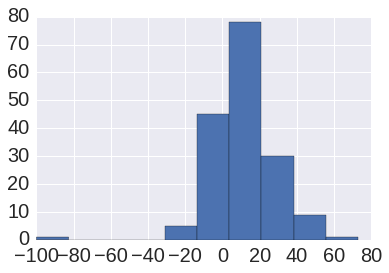

In [550]:
main_df['SYNERGY_SCORE'].hist()

In [551]:
(main_df['SYNERGY_SCORE'] > 20).sum()

43

In [552]:
main_df['SYNERGY_SCORE'] = main_df['SYNERGY_SCORE'] > 20

In [553]:
main_df['SYNERGY_SCORE'].sum()

43

In [554]:
feature_columns = [
    c for c in main_df.columns 
    if main_df[c].dtype in (int, float) and c != 'SYNERGY_SCORE' 
    or print(c)
]

COMBINATION_ID
SYNERGY_SCORE
COMPOUND_A
COMPOUND_B


In [555]:
inputer = Imputer()

In [556]:
clf_options = {
    'loss': 'ls',
    'n_estimators': 900,
    'learning_rate': 0.01,
    'max_depth': 2,
    'subsample': 0.3,
    'random_state': np.random.RandomState(42)
}
clf = GradientBoostingRegressor(**clf_options)

In [557]:
main_df[feature_columns].isnull().any(axis=1).sum()

27

In [558]:
X = inputer.fit_transform(main_df[feature_columns].values)
Y = main_df['SYNERGY_SCORE'].values

In [559]:
X.shape

(169, 50)

In [560]:
clf.fit(X, Y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=2, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=900,
             presort='auto',
             random_state=<mtrand.RandomState object at 0x7f27e0e6e630>,
             subsample=0.3, verbose=0, warm_start=False)

In [561]:
y_pred = clf.predict(X)

(array([ 32.,  53.,  26.,  15.,   0.,   0.,  15.,  19.,   6.,   3.]),
 array([-0.15475169, -0.02276733,  0.10921704,  0.2412014 ,  0.37318576,
         0.50517013,  0.63715449,  0.76913885,  0.90112322,  1.03310758,
         1.16509194]),
 <a list of 10 Patch objects>)

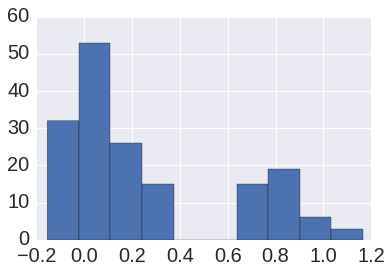

In [562]:
plt.hist(y_pred)

## Make predictions

In [589]:
main_df.head()

,CELL_LINE,COMBINATION_ID,COMPOUND_A,COMPOUND_B,drug_len_A,drug_mean_A,drug_ste_A,drug_len_B,drug_mean_B,drug_ste_B,bg_degree,bg_clustering_coef,bg_betweenness,bg_closeness,bg_neighbor_sharing,bg_shortest_path_length,bg_eb_max,bg_eb_min,bg_eb_mean,bg_eb_fraction,bg_number_of_shortest_paths,coexpression,gene_essentiality,gi_degree,gi_clustering_coef,gi_betweenness,gi_closeness,gi_neighbor_sharing,gi_shortest_path_length,gi_eb_max,gi_eb_min,gi_eb_mean,gi_eb_fraction,gi_number_of_shortest_paths,go_all_sem_sim,go_bp_sem_sim,go_cc_sem_sim,go_mf_sem_sim,go_slim_sem_sim,phylogenic_similarity,s_degree,s_clustering_coef,s_betweenness,s_closeness,s_neighbor_sharing,s_shortest_path_length,eb_max,eb_min,eb_mean,eb_fraction,s_number_of_shortest_paths,drug_len_DIFF,drug_mean_DIFF,drug_ste_DIFF
0,22RV1,ADAM17.AKT_1,ADAM17,AKT_1,85.18,6.07715,2.063913,149.2,16.016789,2.095345,33.8,0.185718,0.000212,0.390061,1.732911,2.4,0.003019,0.000093,0.000207,78.062954,9.8,-0.057905,0.813333,28.333333,0.020605,0.000048,0.339907,0,3,0.000069,0.000003,0.000016,55.47504,16.3333,16.637769,16.17705,26.214286,10.769231,54.297882,0.895341,83.7,0.220766,0.002986,0.311351,0.194932,2.8,0.000282,0.000005,0.000063,62.840766,74,64.02,9.939638,0.031432
1,647-V,ADAM17.AKT_1,ADAM17,AKT_1,85.18,6.07715,2.063913,149.2,16.016789,2.095345,33.8,0.185718,0.000212,0.390061,1.732911,2.4,0.003019,0.000093,0.000207,78.062954,9.8,-0.057905,0.813333,28.333333,0.020605,0.000048,0.339907,0,3,0.000069,0.000003,0.000016,55.47504,16.3333,16.637769,16.17705,26.214286,10.769231,54.297882,0.895341,83.7,0.220766,0.002986,0.311351,0.194932,2.8,0.000282,0.000005,0.000063,62.840766,74,64.02,9.939638,0.031432
2,A549,ADAM17.AKT_1,ADAM17,AKT_1,85.18,6.07715,2.063913,149.2,16.016789,2.095345,33.8,0.185718,0.000212,0.390061,1.732911,2.4,0.003019,0.000093,0.000207,78.062954,9.8,-0.057905,0.813333,28.333333,0.020605,0.000048,0.339907,0,3,0.000069,0.000003,0.000016,55.47504,16.3333,16.637769,16.17705,26.214286,10.769231,54.297882,0.895341,83.7,0.220766,0.002986,0.311351,0.194932,2.8,0.000282,0.000005,0.000063,62.840766,74,64.02,9.939638,0.031432
3,BFTC-905,ADAM17.AKT_1,ADAM17,AKT_1,85.18,6.07715,2.063913,149.2,16.016789,2.095345,33.8,0.185718,0.000212,0.390061,1.732911,2.4,0.003019,0.000093,0.000207,78.062954,9.8,-0.057905,0.813333,28.333333,0.020605,0.000048,0.339907,0,3,0.000069,0.000003,0.000016,55.47504,16.3333,16.637769,16.17705,26.214286,10.769231,54.297882,0.895341,83.7,0.220766,0.002986,0.311351,0.194932,2.8,0.000282,0.000005,0.000063,62.840766,74,64.02,9.939638,0.031432
4,BT-20,ADAM17.AKT_1,ADAM17,AKT_1,85.18,6.07715,2.063913,149.2,16.016789,2.095345,33.8,0.185718,0.000212,0.390061,1.732911,2.4,0.003019,0.000093,0.000207,78.062954,9.8,-0.057905,0.813333,28.333333,0.020605,0.000048,0.339907,0,3,0.000069,0.000003,0.000016,55.47504,16.3333,16.637769,16.17705,26.214286,10.769231,54.297882,0.895341,83.7,0.220766,0.002986,0.311351,0.194932,2.8,0.000282,0.000005,0.000063,62.840766,74,64.02,9.939638,0.031432


In [590]:
X = inputer.transform(main_df[feature_columns].values)

In [591]:
main_df['SYNERGY_SCORE'] = clf.predict(X)

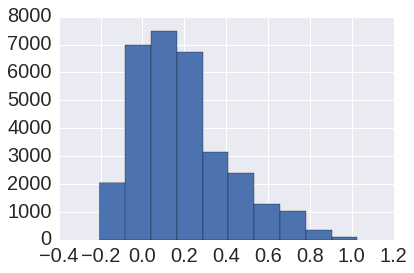

In [592]:
main_df['SYNERGY_SCORE'].hist()

In [593]:
main_df.loc[main_df['SYNERGY_SCORE'] < 0, 'SYNERGY_SCORE'] = 0

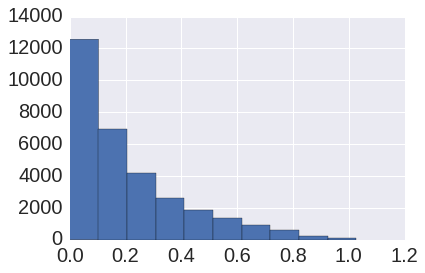

In [594]:
main_df['SYNERGY_SCORE'].hist()

In [595]:
df1 = main_df.copy()

In [596]:
df = main_df.pivot(index='COMBINATION_ID', columns='CELL_LINE', values='SYNERGY_SCORE')
df.sort_index(axis=0, inplace=True)
df.sort_index(axis=1, inplace=True)

In [597]:
df.to_csv('/home/kimlab1/strokach/working/az_dream/output/ch2_1/submission_2/confidence_matrix.csv', quoting=2)

In [598]:
df2 = (df > 0.2).astype(int)

In [599]:
df2.to_csv('/home/kimlab1/strokach/working/az_dream/output/ch2_1/submission_2/synergy_matrix.csv', quoting=2)